#Machine Learning Mini Project: Modelling Martian Weather

---

Completed 05-01-2021

---

# 1. Introduction

NASA has publicly available data for many of its missions, and two potential candidates came to mind when it came to weather modelling - namely the Mars Science Laboratory Curiosity Rover, and the InSight lander. Both missions had instrumentation for detecting temperature, windspeed and wind direction, and NASA currently runs pages displaying the weather, derived from those measurements, at any given moment.

After shopping around the NASA website, the InSight data was found to be readily available from the Planetary Data Sciences (PDS) website, in a public directory. Moreover, inspection of the data files, available as comma separted CSVs, showed that the instruments sampled at 1 Hz, with several thousand measurements per day. This was a bit excessive for this project, but was a significant step up in quality and reliability from the GHCND data.

As such, this notebook has three specific tasks:

1. Deliver a fast, scalable approach to retrieving InSight data
2. Use the data to build appropriate temperature and wind models
3. Investigate the applicability of these models in a space exploration context

The code here could readily be adapted to many of the other missions that have archived sensor data with small adjustments to the early file formatting functions being the only necessary step. This is not done in this notebook due to time constraints, but remains a potential avenue of investigation.


# 2. Data Retrieval Functions

## 2.1 Imports and setup
---

The same set of libraries as used in the first notebook are imported here, including Tensorflow and Keras, along with `urllib` for getting data over the internet. As before, we are suppressing warnings over ragged arrays or depracation notices. Not included are the `ipywidget` utilities, as there are no interactable elements in this notebook.

In [ ]:
#Standard imports
import urllib
from datetime import *
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras

#Import warnings and ipywidgets for the climate map
import warnings

#Suppress specific warnings to prevent cluttering the output
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", category=DeprecationWarning)            
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


In [ ]:
a = ["a", "1", "2"]
a[1], a[2] = float(a[1]), float(a[2])
print(a)

['a', 1.0, 2.0]


##2.2 Enumerating the PDS Atmospheres Node - `MARS_getData()`

While the InSight data could be found in a public directory on NASA's PDS Atmosphere Node, it seemed prudent to first look for official download utilities or analytical tools provided on the website. Unfortunately, these were limited in scope, requiring files to be requested one at a time, or through their "Data Analyst's Notebook" system, which again required manual selection of data files. Additional routes were by submitting newline separated file identifiers through a form page, or anonymous FTP access.

Looking through the public folders, there appeared to be 608 files, one for each Sol of the mission until the end of October 2020 (as of Jan. 2021). Downloading these by hand was out of the question, and so an alternative method was created.

The `MARS_getData` function automatically enumerates the root directory of the InSight directory, identifying folders, before searching through those folders recursively to identify the names of the files containing usable data. It operates as below.

1. `GET` request to the root `data_calibrated` directory
2. Decode and scrape the response for folder names, in the format `sol_xxx_yyy`
3. Iterate over folder names and send `GET` requests to the `data_calibrated\sol_xxx_yyy` directories
4. Scrape those responses for the filenames, in the format `twins_calib_XXXX_01.csv`

These filenames are then saved into an array and returned.

In [ ]:
def MARS_getData():
  '''
  Quick and dirty scraper for the Planetary Data Science archive, retrieves
  the URIs for the InSight data files (CSVs)

  Returns:

  completeURIs [ARR]
              The full URIs for each data file

  '''

  #Return array for the links
  completeURIs = []

  #Make a basic GET request to the root directory
  print("[+] Mapping NASA InSight PDS Directories\n|")
  folders = urllib.request.urlopen("https://atmos.nmsu.edu/PDS/data/PDS4/InSight/twins_bundle/data_calibrated/")

  #Convert the data from byte encoding and split the lines
  fData = folders.read().decode().splitlines()

  #Iterate over the lines and regex the subdirectory names
  for f in fData:
      if "sol_" in f:
          dataCount = 0

          #Get the name of the directory and GET it as well
          dir = f.split("</a>")[0].split(">")[-1]
          resp = urllib.request.urlopen("https://atmos.nmsu.edu/PDS/data/PDS4/InSight/twins_bundle/data_calibrated/"+dir)

          #Decode the response and enumerate the files in this subdir
          data = resp.read().decode().splitlines()
          print("|----[+] Found directory:", dir, end="")
          for d in data:
              if "twins_calib_" in d and "csv" in d:
                  completeURIs.append(("https://atmos.nmsu.edu/PDS/data/PDS4/InSight/twins_bundle/data_calibrated/" + dir + d.split("</a")[0].split('.csv">')[1]))
                  if(len(completeURIs[-1]) < 20):
                      completeURIs.pop(-1)
                  else:
                    dataCount += 1

          #Output the number of files found in this folder
          print(" -", dataCount, "files", end="")
          if dataCount > 0:
            print("\t [OKAY]")
          else:
            print("\n [WARN]")


  #Return the files that were found (should be ~535)
  print("\n[+] Enumeration completed")
  print("[+] Found", len(completeURIs), "data files\n")
  return completeURIs


## 2.2 File retrieval - `MARS_getFile()`
---
Next, the `MARS_getFile` function is defined. This is a simple method built on `urllib` for retrieving files from a specific URL, decoding it from a bytes-like format into a string, and splitting the lines.

This was designed to be called in a loop, allowing for multiple files to be downloaded in quick succession. A verbose mode was made available for debug reasons, although it is never used in this notebook, and notifies the user if a file has zero data (i.e is empty). 

In [ ]:
def MARS_getFile(path, id=None, verbose=True):
  '''
  Downloads a file from the PDS archive and perform some basic decoding.
  
  Inputs:
  
  path  [URI]
              The link to the file
  id    [INT]
              An ID for this download, useful for progress bars
  verbose [BOOL]
              Whether to print a progress update when done

  Returns

  data  [ARR] 
              The lines in the file
  '''

  #Announce the beginning of the process
  if verbose:
    print("[+] DOWNLOAD\tID", id, "\t", end="")

  #Get the file from the server and decode it
  f = urllib.request.urlopen(path)
  data = f.read().decode().splitlines()

  #Check if the data is empty and display a warning, and lastly return it
  if len(data) > 0 and verbose:
    print("[OKAY]")
  if len(data) == 0:
    print("[ERNZ]")
  return data

## 2.3 Data reduction - `MARS_selectData()`
---
The InSight data contains several different variables, but there are three core masurements being made by the TWINS instrument - air temperature, wind speed and wind direction. There are a number of other measurements, but they are of the same metrics in different locations on the lander (such as the tip of the temperature probe vs the base). Excluding these relatively similar variables quickly cuts down the memory footprint of the program, and speeds up processing. As the data is sampled once per second, or twice in some circumstances, reducing this to hourly data also seemed prudent, to reduce noise and allow for easier handling and training of the models.

This reductive process is performed by the `MARS_selectData` function, which by default samples every 3600th measurement, amounting to hourly measurements. No binning is carried out, or averaging. The data is filtered to only specifed variable types in the process.



In [ ]:
def MARS_selectData(inData, variables, interval=3600):
  '''
  Iterates over a downloaded file and pulls requested measurements from it,
  taking one value out of every 3600 by default (i.e one measurement per hour)

  Inputs:

  inData [ARR]
              The line-split file (from MARS_getFile())
  
  variables [ARR]
              The measurement types to retrieve
  
  interval [INT]
              How many files to skip between saving values
  
  Returns:

  dataArrays [ARR]
              Arrays of values for each measurement type
  
  validHeadings [ARR]
              The names of the measurements succesfully extracted
  
  complete [BOOL]
              Whether any invalid or missing data was encountered
  '''

  #Return variables for this function
  columns = []
  validHeadings = []
  complete = True 

  #Extract the measurements available in this file
  headings = inData[0].strip().split(",")

  #CHeck to see which of the requested measurements are contained here
  for v in variables:
      try:
          index = headings.index(v)
          columns.append(index)
          validHeadings.append(v)
      except:
          pass
  
  #Return array for the parsed dataset
  dataArrays = []

  #Iterate over the raw data retrieved from the file, skipping over the headings
  for c in columns:
      data = []
      for l in range(1, len(inData[1:]), interval):
          line = inData[l]

          #Split the comma separated values
          values = line.strip().split(",")

          #If a value is missing, try and use the one before. If this is the first,
          #mark the file as invalid. If valid, append it to the file.
          if values[c] == '':
            try:
              data.append(data[-1])
            except:
              data.append(-9999)
              complete = False
          else:
            data.append(values[c])
      
      #Save this measurements data
      dataArrays.append(data)

  #Return the overall dataset
  return np.array(dataArrays), validHeadings, complete

## 2.4 Retyping and formatting the data - `MARS_formatData()`
---
Thus far in the processing, no operations have been carried out on the array elements themselves, which are currently stored as strings rather than floats or time objects. The `MARS_formatData` function carries out this task, identifying dates and converting them to ISO8601 formats that are readable by Python modules like `numpy` or `matplotlib`. 

Numbers are converted to `np.float32` formats, which prevents type errors when used as inputs for neural networks. However, the arrays are retyped when used in training as a precautionary measure, as manipulations in other functions can cause the types to be invalidated.

In [ ]:
def MARS_formatData(inData, variables):
  '''
  Formats the restructured data from MARS_selectData(), which is all typed
  as strings, rather than dates or floats as required. 

  Inputs:
  
  inData [ARR]
              The data to format
  
  variables [ARR]
              The corresponding headings for the data (i.e the validHeadings)
              from the previous function
  
  Returns:

  finalRet [ARR]
              The reformatted data structure
    
  '''

  #Return variable
  finalRet = []

  #Iterate over the headings, and convert the weird NASA YYYY-DDDTHH:MM:SS.S format
  #to something ISO8601 compatable
  for i in range(0, len(variables)):
    if variables[i] == "UTC":
      tArr = []
      for t in range(0, len(inData[i])):
        dateString = inData[i][t]
        yearMonth, dayTime = dateString.split("T")
        year, day = yearMonth.split("-")
        dayTime = datetime.strptime(dayTime[:-2], "%H:%M:%S.%f")
        dt = datetime(int(year), 1,1) + timedelta(int(day)) + timedelta(hours=dayTime.hour, minutes=dayTime.minute, seconds=dayTime.second)
        tArr.append(dt)

      #Save the reformatted date
      finalRet.append(np.array(tArr))
    
    #For all other variables, retype them to floats
    else:
      try:
        newArr = inData[i,:].astype(np.float32)
        finalRet.append(newArr)
      except:
        pass
  
  #Return the reformatted array
  return np.array(finalRet)

## 2.5 Combining file retrieval and formatting - `MARS_heist()`
---

The final function is named `MARS_heist` due to its unusual method for retrieving data from the PDS Atmosphere Node's file server. This function combines the utilities defined above, locating data files, downloading them, reducing the data, and formatting it.

The `MARS_selectData` function also notifies this function of any anomalies in the input datasets, such as missing data or irreconcilable errors. After some experimentation, it was found to be easier to simply discard problematic datasets, as it had a limited impact on the training, and simplified much of the data handling. 

In [ ]:
def MARS_heist(dataPaths, parameters):
  '''
  This uses the previously defined functions to enumerate, download and format
  all of the InSight data, and get it ready for use and modelling. It takes a 
  while, but its as fast as it can be.

  Inputs:

  dataPaths [ARR]
              The list of URIs to get files from

  parameters [ARR]
              The data types to get

  Returns:

  processedData [ARR]
              The formatted data
  
  processedLabels [ARR]
              The headings of the different data types retrieved
  '''

  #Return variables
  processedData = []
  processedLabels = []

  #Counter for the number of valid files found
  validCount = 0

  #Iterate over all the URIs and get each file
  print("[+] Pulling and processing data")
  for i in range(0, len(dataPaths)):

    #Download, get the data, and format it
    retrievedFile = MARS_getFile(dataPaths[i], id=i+1, verbose=False)
    data, labels, complete = MARS_selectData(retrievedFile, parameters)
    fData = MARS_formatData(data, labels)

    #If the file isn't missing any data, add to the count and save the data
    if(complete):
      validCount += 1

      #If no data has been processed yet, use this set to configure the return array
      if processedData == []:
        print("|")
        processedData = fData
        processedLabels.append(labels)

      #Otherwise just concatenate the columns to make a contiguous dataset
      else:
        processedData = np.concatenate((processedData, fData), axis=1)
        processedLabels.append(labels)

    #Progress update, notify for every 100 processed files
    if((i+1) % 100 == 0):
      print("|----[+] Retrieved:", i+1, " // Validated:", validCount, end="")
      if (validCount / i+1) > 0.6:
        print("\t\t[OKAY]")
      else:
        print("\t\t[LACQ]")

  #Return the formatted data
  print("\n[+] Done. Validated", validCount, "files in total.")
  return processedData, processedLabels

#3.  Date Extraction and Formatting

## 3.1 Downloading 
---

The first code execution is carried out with `MARS_heist`, and usually takes ~5 minutes to run. This retrieves the initial dataset, which can then be reused by every other function. Each CSV data file is approximately 16MB, so retrieving ~600 represents a relatively sizeable download. The function also keeps the user informed of discovered files, as well as the progress made as it goes along. The number of files actually used by the program is typically around ~80% of the available files, as the remaining ~20% are discarded due to defects. The number of files downloaded may vary according to what files are currently on the server, but the code is agnostic to these changes, and should perform reliably.

In [ ]:
#Get the data paths, and rip it all from the server
MARS_dataPaths = MARS_getData()

#Retrieve the time, air temperature, wind speed, and wind direction data
MARS_data, MARS_labels = MARS_heist(MARS_dataPaths, ["UTC", "BMY_BASE_ROD_TEMP", "BMY_HORIZONTAL_WIND_SPEED", "BMY_WIND_DIRECTION"])

[+] Mapping NASA InSight PDS Directories
|
|----[+] Found directory: sol_0000_0122/ - 105 files	 [OKAY]
|----[+] Found directory: sol_0123_0210/ - 88 files	 [OKAY]
|----[+] Found directory: sol_0211_0300/ - 76 files	 [OKAY]
|----[+] Found directory: sol_0301_0389/ - 89 files	 [OKAY]
|----[+] Found directory: sol_0390_0477/ - 88 files	 [OKAY]
|----[+] Found directory: sol_0478_0566/ - 89 files	 [OKAY]
|----[+] Found directory: sol_0567_0668/ - 73 files	 [OKAY]
|----[+] Found directory: sol_0669_0745/ - 58 files	 [OKAY]

[+] Enumeration completed
[+] Found 666 data files

[+] Pulling and processing data
|
|----[+] Retrieved: 100  // Validated: 60		[OKAY]
|----[+] Retrieved: 200  // Validated: 125		[OKAY]
|----[+] Retrieved: 300  // Validated: 215		[OKAY]
|----[+] Retrieved: 400  // Validated: 307		[OKAY]
|----[+] Retrieved: 500  // Validated: 400		[OKAY]
|----[+] Retrieved: 600  // Validated: 496		[OKAY]

[+] Done. Validated 553 files in total.


##3.2 Normalisation
---
As with other weather data, each component of the InSight data is normalised by subtracting the mean and dividing by the standard deviation. Wind direction is normalised to between 0 and 1 by simply dividing by 360, as it is referenced as a bearing in the files. The means and standard deviations are then saved in separate arrays. This excludes the first column of the data retrieved, which is assumed to contain the dates of the measurements. 

Importantly, the data retrieved by the `MARS_heist` function is not overwritten, and the normalised values are stored in a new variable. This is to prevent unnecessary requests being sent to the PDS nodes every time a clean dataset is needed, which would consume considerable bandwidth.

In [ ]:
#Arrays for storing the means and standard deviations of each parameter
MARS_means = []
MARS_stds = []

#Get a copy of the data for normalisation rather than overwriting it
MARS_normData = np.copy(MARS_data)

#Iterate over each parameter, excluding the first and last (UTC and wind dir)
#and normalise them
for x in range(1, len(MARS_data)-1):
  MARS_means.append(np.mean(MARS_normData[x,:]))
  MARS_normData[x,:] -= MARS_means[-1]
  MARS_stds.append(np.std(MARS_normData[x,:]))
  MARS_normData[x,:] /= MARS_stds[-1]

#Divide the wind direction by 360 to get it between 0 and 1
MARS_means.append(0)

MARS_stds.append(360)
MARS_normData[-1,:] /= 360. 


## 3.3 Inspection
---
Before any analysis is carried out, the downloaded data is inspected for serious errors, or any defects that might affect the validity of the training process. Below, six graphs are shown. The top row shows the data from the month of June 2020, arbitrarily chosen. The bottom row shows the same variables, but for the entire duration of the measurements. 

Preliminary visual inspection inidcates that on the scale of days, temperature, wind speed and wind direction are all periodic in nature, improving the viability of predictive models. As can be seen, there are a few gaps in the dataset, with the beginning months of the mission more patchy than the latter ones. The only serious exceptions are two large gaps in September 2019 and 2020, but the continuity of the data elsewhere is ideal for analysis. 

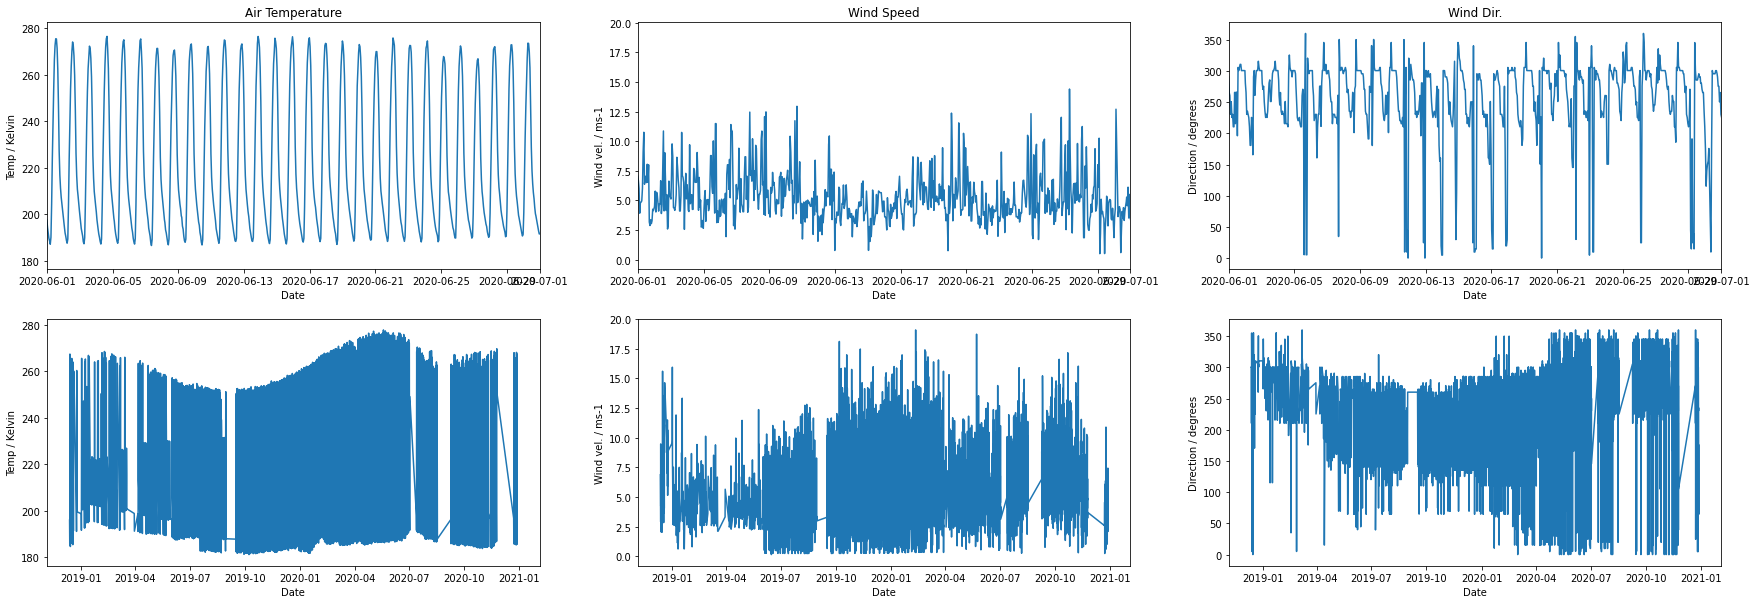

In [ ]:
#Give a quick overview of the data
MARS_varUnits = ["Temp / Kelvin", "Wind vel. / ms-1", "Direction / degrees"]
MARS_headings = ["Air Temperature", "Wind Speed", "Wind Dir."]
fig, ax = plt.subplots(2,3, figsize=(30,10))
for i in range(1,4):
  ax[0][i-1].plot(MARS_data[0,:], MARS_data[i,:])
  ax[0][i-1].set_title(MARS_headings[i-1])
  ax[0][i-1].set_xlabel("Date")
  ax[0][i-1].set_ylabel(MARS_varUnits[i-1])
  ax[0][i-1].set_xlim(date(2020,6,1), date(2020,7,1))

  ax[1][i-1].plot(MARS_data[0,:], MARS_data[i,:])
  ax[0][i-1].set_title(MARS_headings[i-1])
  ax[1][i-1].set_xlabel("Date")
  ax[1][i-1].set_ylabel(MARS_varUnits[i-1])


## 3.4 Converting the data to ML-compatable formats
---
As with the GHCND data, the data here is chunked into windows of training inputs by `MARS_getTrainingWindows`, also producing an associated label or prediction value. Unlike with the GHCND data handling, there is no error correction to account for temporal gaps in measurement. This was not based on the assumption that there were an insignificant number of gaps ~100 days of data are usually discarded during retrieval. Instead, it relies on the periodicity of the data. 

As the amplitude of the oscillations are consistent in magnitude, and each file starts and ends at the same time of day, removing whole files means that the data jumps from local midnight on one sol, to local midnight on another. As the oscillations of the variables appear to be a function of the time of day, this results in the final values of each day being close to the start value of any other, allowing them to be "stitched" together if a break is encountered in the data, something that was not possible with the GHCND data. This is visible on the graphs, where most of the lines crossing the gaps are either relatively close to horizontal, or only represent small proportional changes when compared to the range of the data.

In [ ]:
def MARS_getTrainingWindows(inData, windowSize, predTime):
  '''
  Converts the formatted InSight data into the usual batches and labels
  for training.

  Inputs:

  inData [ARR]
              The formatted Mars data from the initial download / formatting
  
  windowSize [INT]
              Number of values to include in the training inputs
  
  predTime [INT]
              The number of hours to predict in advance

  Returns:

  data [ARR]
              The batch inputs
  
  labels [ARR]
              The values that the inputs should predict
  
  labelTimes [ARR]
              The date of the predicted value (for plotting)
  '''
  
  #Return arrays
  data = []
  labels = []
  labelTimes = []

  #Iterate over the data and construct the batches
  for i in range(0, len(inData[0])-predTime-windowSize):
    data.append(inData[1:,i:i+windowSize])
    labels.append(inData[1:,i+windowSize+predTime])
    labelTimes.append(inData[0,i+windowSize+predTime])
  
  #Return the batches and labels 
  print("[+] Generated", len(data), "batches\n")
  return np.array(data), np.array(labels), np.array(labelTimes)

As might be expected, a function is used to split this complete set of batched data into training, validation and test data for the models. This is done in the `MARS_getSets` function by using user defined fractions to slice between the first and last index of the input data. This is carried out in a single line for the sake of neatness.

In [ ]:
def MARS_getSets(inData, inLabels, inTimes, trainFrac, validFrac):
  '''
  Splits a full set of generated data into training, validation and test sets

  Inputs:

  inData, inLabels, inTimes [ARR]
          The complete set of input batches, their labels and dates
  
  trainFrac [FLOAT]
          The fraction of the dataset to use in training 
  
  validFrac [FLOAT]
          The fraction of the dataset to use for validation
    
  '''

  #Calculate the end positions of the training and validation sets
  trainIndex = int(trainFrac * len(inData))
  validIndex = trainIndex + int(validFrac * len(inData))

  #Output the size of each set
  print("[+] Training set: 0 ->", trainIndex-1)
  print("[+] Validation set:", trainIndex,"->",validIndex-1)
  print("[+] Testing set:", validIndex, "->", len(inData)-1)

  #Format the datasets and return them
  trainDataLabels = inData[:trainIndex,:].reshape(*inData[:trainIndex,:].shape, 1), inLabels[:trainIndex,:]
  validDataLabels = inData[trainIndex:validIndex,:].reshape(*inData[trainIndex:validIndex,:].shape, 1), inLabels[trainIndex:validIndex,:]
  testDataLabelTime = inData[validIndex:,:].reshape(*inData[validIndex:,:].shape, 1), inLabels[validIndex:,:], inTimes[validIndex:]

  return trainDataLabels, validDataLabels, testDataLabelTime

## 3.5 Model structure and training 
---
Next, two functions are defined. `MARS_getModel1D` returns an untrained model for use, while `MARS_trainModel1D_generic` is used to train it with an arbitrary input and output variable type, specified using an integer identifier. Due to the clear periodicity of the data, a relatively simple network architecture is used here, in order to maximise the speed of training, and allowing for a wide variety of inputs and outputs to be tested. As the measurements were all made at precisely the same moment, and the arrays are all of the same size, any input can be used with any output, allowing for a wide variety of models to be constructed.
These functions are broadly similar to the functions in the first notebook, but are somewhat more streamlined due to the more narrow focus of this task.

In [ ]:
def MARS_getModel1D():
  '''
  Returns a single input, single output LSTM model for use in the weather modelling

  Returns:

  An untrained model [NN]

  '''

  #Build a simple model with 32 LSTM neurons feeding into a single dense layer
  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(32,input_shape=(None,1),return_sequences=False))
  model.add(keras.layers.Dense(20,activation="linear"))
  model.add(keras.layers.Dense(1,activation="linear"))

  #Compile and return the model
  model.compile(loss='mean_absolute_error',optimizer='adam')
  return model

def MARS_trainModel1D_generic(model, trainSet, validSet, inputIndex, outputIndex):
  '''
  Trains a model on a specified training and validation dataset, with customisable
  inputs and outputs.

  Inputs:

  model [NN]
            An unfitted, compiled, single input network

  trainSet, validSet [ARR]
            The training and validation datasets to use

  inputIndex, outputIndex [INT]
            Which arrays within the dataset to use as the inputs and outputs - 
            0,0 would be using temp to predict temp
            0,1 is temp to predict windspeed
            1,0 is windspeed to predict temp and so on
  '''

  #Train the model and extract the costs. Recast everything to np.float32 just in case.
  costs = model.fit(trainSet[0][:,inputIndex,:,:].astype(np.float32), trainSet[1][:,outputIndex].astype(np.float32), batch_size=32, epochs=32, validation_data=(validSet[0][:,inputIndex,:,:].astype(np.float32), validSet[1][:,outputIndex].astype(np.float32)), verbose=0)
  return costs

The training function above is wrapped by the `MARS_buildGenericModel` function here. This provides a higher level interface for making and comparing predictions of weather measurements, by automatically building datasets for the requested variables, training a model, and then making and graphing predictions. In addition, it handles the data postprocessing, restoring the outputs from their normalised states back into something human-interpretable. 

In [ ]:
def MARS_buildGenericModel(model,data, inIndex, outIndex, means, stds, windowSize, predTime, daterange=[date(2020,9,16), date(2020,10,15) ]):
  '''
  Builds an appropriat dataset for the requested parameters, trains a model and
  displays the network performance by comparing the predicted and actual values
  of the test dataset.

  Input:

  model [NN]
            The untrained model to use in predictions
  
  data [ARR]  
            The retrieved InSight dataset
  
  inIndex, outIndex [INT]
            The indices of the input and output variable arrays in the dataset
  
  means, stds [ARR]
            The arrays containing the means and standard deviation sof the data
            for plotting
  
  windowSize [INT]
            The number of values to put in the input batches
  
  predTime [INT]
            How many hours in advance to predict

  Returns:

  A graph of the predictions, and trains the supplied model (no return var
  needed for this, as the model.fit method updates it internally)
  '''

  #Get the training, validation and testing data, and use it to train the model
  MARS_trainSet, MARS_validSet, MARS_testSet = MARS_getSets(*MARS_getTrainingWindows(data, windowSize, predTime), 0.7, 0.2)
  costs = MARS_trainModel1D_generic(model, MARS_trainSet, MARS_validSet, inIndex, outIndex)

  print("\n[!] Final training loss:", round((costs.history['loss'][-1])*stds[outIndex], 2))
  print("[!] Final validation loss:", round((costs.history['val_loss'][-1])*stds[outIndex], 2))

  #Predict on the test data
  predictedValues = model.predict_on_batch(MARS_testSet[0][:,inIndex,:,:].astype(np.float32))


  #Plot the real and predicted test values
  fig, ax = plt.subplots(1,1, figsize=(20,5))

  ax.set_title("Model predictions for " + MARS_headings[outIndex] + " at T+" + str(predTime) + " hrs")

  ax.plot(MARS_testSet[2], predictedValues*stds[outIndex] + means[outIndex], label="Predicted")
  ax.plot(MARS_testSet[2], MARS_testSet[1][:,outIndex]*stds[outIndex]+means[outIndex], '--',label="Actual")
  ax.set_xlim(daterange)

  ax.set_xlabel("Date")
  ax.set_ylabel(MARS_varUnits[outIndex])
  plt.legend(framealpha=1.0)

#4. Weather forecasts for Elysium Planitia

##4.1 Temperature predictions
---

The primary objective of this investigtion was to create effective models of Martian weather, but specifically using small input windows, to account for the 

The natural starting point for experimentation was air temperature prediction. The two hidden layer network defined earlier was fitted to the data using 32 epochs, each one with a batchsize of 32 data frames.

The first model uses a single temperature measurement to forecast a full Sol in advance. For the test batch, this functioned surprisingly well, matching the shape of the daily fluctuations well, and even predicting the more subtle increase and decrease in of maximum and minimum temperatures over time. However, the testing and validation mean absolute errors of ~10 and ~7 degrees respectively indicates that this may not be entirely representative of the performance across the entire dataset.


[+] Generated 10832 batches

[+] Training set: 0 -> 7581
[+] Validation set: 7582 -> 9747
[+] Testing set: 9748 -> 10831

[!] Final training loss: 9.57
[!] Final validation loss: 7.45


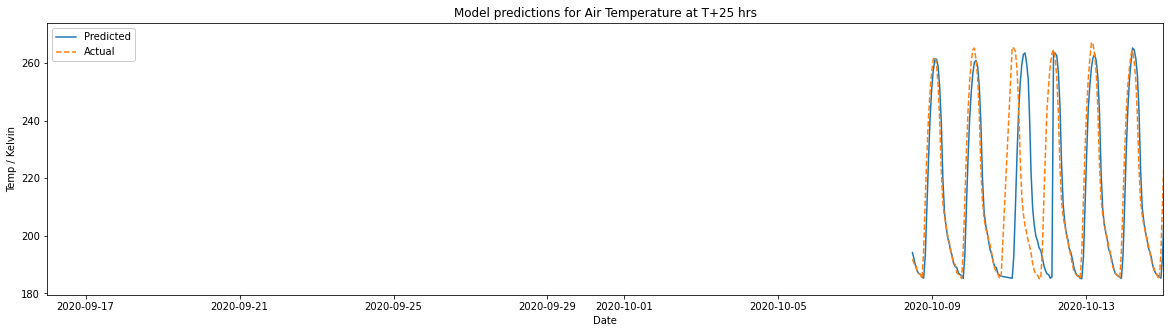

In [ ]:
#Build a temp -> temp model, predict 1 Sol in advance
MARS_model_TT = MARS_getModel1D()
TT_costs = MARS_buildGenericModel(MARS_model_TT,MARS_normData,0,0,MARS_means, MARS_stds, 1,25)

Next, a more ideal case is investigated, using a full day's set of measurements, 25 in total, to predict the next Sol's weather. This drastically reduces the training and validation losses, reducing them by approximately a factor of two, and the fit on the test dataset appears to be much tighter, bar a sudden spike in the final few days.

[+] Generated 10808 batches

[+] Training set: 0 -> 7564
[+] Validation set: 7565 -> 9725
[+] Testing set: 9726 -> 10807

[!] Final training loss: 5.06
[!] Final validation loss: 3.94


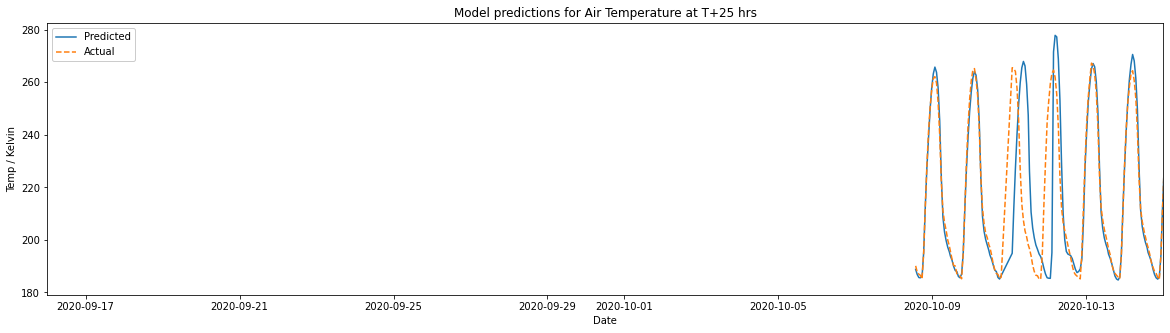

In [ ]:
#Build a temp -> temp model, predict 1 Sol in advance
MARS_model_TT_25 = MARS_getModel1D()
TT_25_costs = MARS_buildGenericModel(MARS_model_TT_25,MARS_normData,0,0,MARS_means, MARS_stds, 25,25)

The next case that is investigated is the most basic - predicting the weather one hour in advance. This system is of particular use, as it could be used to generate continuous predictions that extend an arbitrary distance into the future, in the style of the climate modelling in the previous task. Here, six values are used to predict the next one, as this proved more stable. Again, the same anomalous spike is present, on the same day as the other models.

[+] Generated 10851 batches

[+] Training set: 0 -> 7594
[+] Validation set: 7595 -> 9764
[+] Testing set: 9765 -> 10850

[!] Final training loss: 3.99
[!] Final validation loss: 3.97


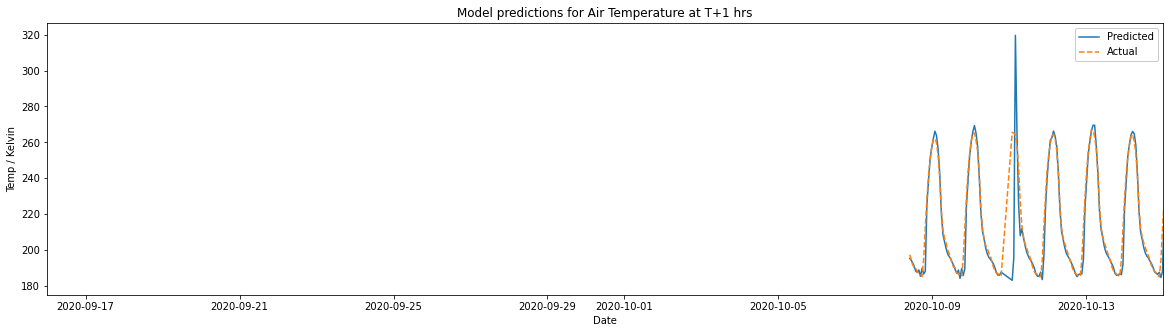

In [ ]:
#Build a temp -> temp model, predict 1 Sol in advance
MARS_model_TT_next = MARS_getModel1D()
TT_next_costs = MARS_buildGenericModel(MARS_model_TT_next,MARS_normData,0,0,MARS_means, MARS_stds, 6,1)

The final case is at the other extreme, attempting to predict 175 hours, or 7 sols, in advance. Here, a similar window size to the one before is used. Unfortunately, this was not quite as functional as the other models, and might require a little more processing to derive usable metrics from. Models predicting a month in advance were tested, but generally had poor performance, and are excluded from this notebook.

[+] Generated 10658 batches

[+] Training set: 0 -> 7459
[+] Validation set: 7460 -> 9590
[+] Testing set: 9591 -> 10657

[!] Final training loss: 11.64
[!] Final validation loss: 12.19


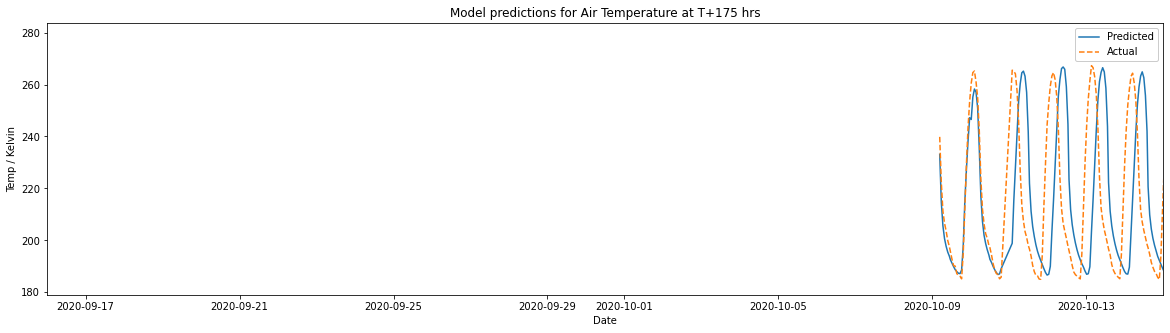

In [ ]:
#Build a temp -> temp model, predict 30 Sols in advance
MARS_model_TT_week = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_TT_week,MARS_normData,0,0,MARS_means, MARS_stds, 25,175)

## 4.2 Windspeed forecasting
---

This was something of an unknown from the outset, as no wind modelling was done during the core tasks. As done before, window sizes were minimised, and the predictions were made one Sol in advance. The first model uses short input windows of 3 hours, and this is shown below. Training and validation losses were low, with a MAE of ~1.65 m/s. A slightly narrowed plot is shown below, as the full 40 day data was hard to inspect due to the combined noisiness of the real and predicted data. As can be seen, the model does indeed match the broad shape of the data, and succesfully identifies many of the peaks in windspeed. This was a surprise, given how unpredictable precise wind speed tends to be. 

[+] Generated 10831 batches

[+] Training set: 0 -> 7580
[+] Validation set: 7581 -> 9746
[+] Testing set: 9747 -> 10830

[!] Final training loss: 1.67
[!] Final validation loss: 1.83


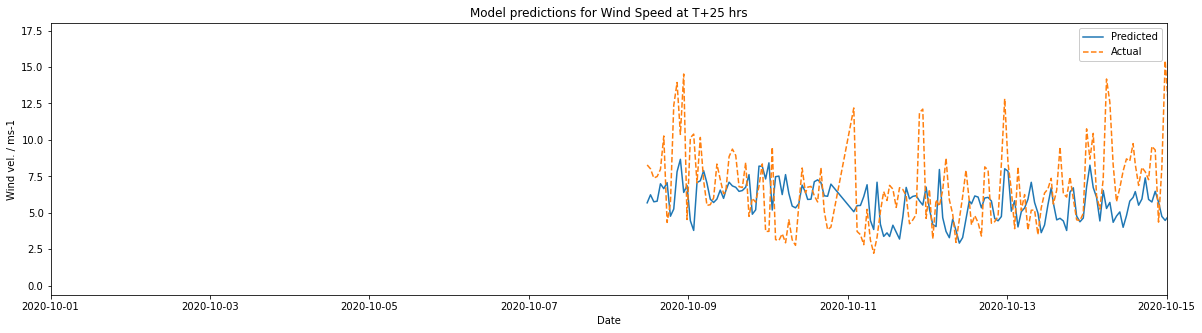

In [ ]:
#Build a windspeed -> windspeed model, predict 1 Sol in advance
MARS_model_WW = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_WW,MARS_normData,1,1,MARS_means, MARS_stds, 2,25, daterange=[date(2020,10,1), date(2020,10,15)])

For illustrative purposes, a model trained using 25 sets of wind measurements to predict with the same lead time is shown below. Some analysis on this phenomenon is carried out in the report, but there is a clear flattening of the predictions, and a qualitatively less descriptive plot. However, the training and validation losses are both slightly lower.

[+] Generated 10808 batches

[+] Training set: 0 -> 7564
[+] Validation set: 7565 -> 9725
[+] Testing set: 9726 -> 10807

[!] Final training loss: 1.48
[!] Final validation loss: 1.92


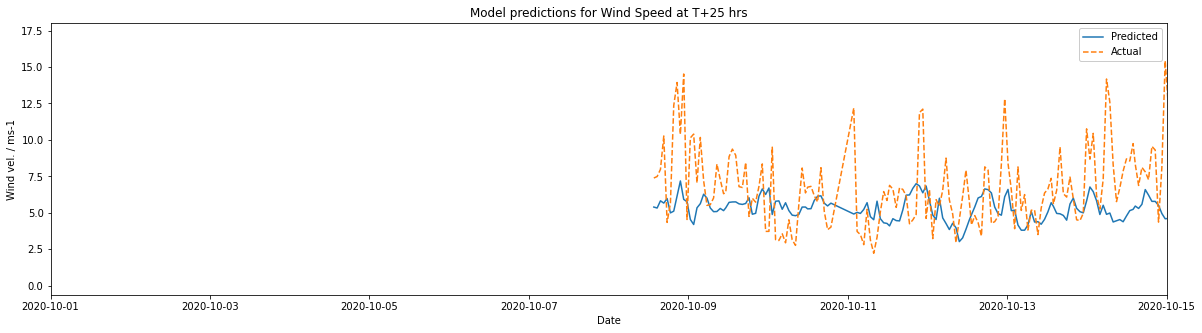

In [ ]:
#Build a windspeed -> windspeed model, predict 1 Sol in advance
MARS_model_WW_25 = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_WW_25,MARS_normData,1,1,MARS_means, MARS_stds, 25,25, daterange=[date(2020,10,1), date(2020,10,15)])

Lastly, a one week model is attempted. This fails to generate usable predictions, bar a baseline level of noise, but this is likely of little functional usage compared to the other models.

[+] Generated 10658 batches

[+] Training set: 0 -> 7459
[+] Validation set: 7460 -> 9590
[+] Testing set: 9591 -> 10657

[!] Final training loss: 1.69
[!] Final validation loss: 2.26


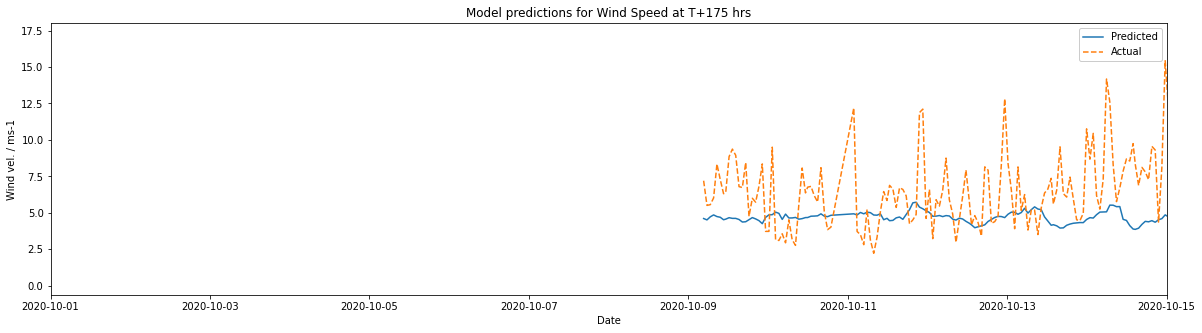

In [ ]:
#Build a windspeed -> windspeed model, predict 1 Sol in advance
MARS_model_WW_week = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_WW_week,MARS_normData,1,1,MARS_means, MARS_stds, 25,175, daterange=[date(2020,10,1), date(2020,10,15)])

##4.3 Wind direction forecasting

---

The final parameter being assessed is the wind direction. There are some issues with the dataset, specifically concerning the unphysical jumsp from a bearing of 359 to a bearing of 0, which while only representing a single degree rotation in the real world, is a large spike in the data. Despite this, daily forecasting of the wind direction seems entirely possible, with many of the features well described by the network.

 Excluding unphysical jumps could be done simply using the cosine of the bearing rather than the normalised bearing, but this was left as an exercise for the reader due to this project's time constraints. Nevertheless, even this rudimentary daily model functions well as a proof of concept.

[+] Generated 10830 batches

[+] Training set: 0 -> 7579
[+] Validation set: 7580 -> 9745
[+] Testing set: 9746 -> 10829

[!] Final training loss: 29.19
[!] Final validation loss: 31.0


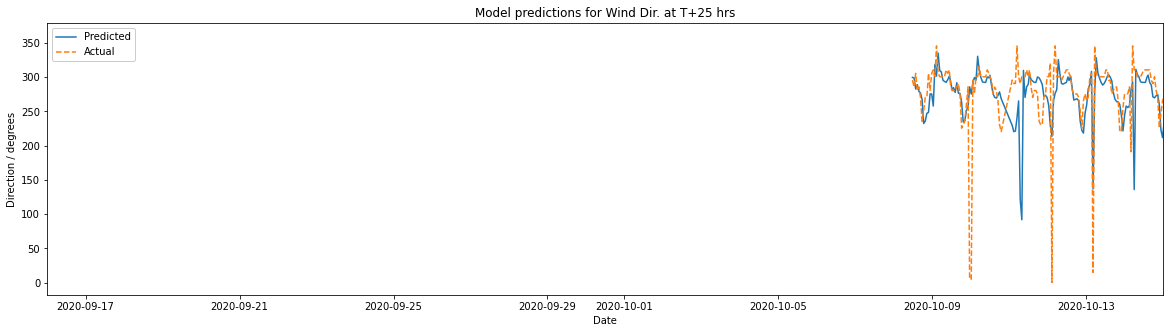

In [ ]:
#Build a wind direction -> wind direction model, predict 1 Sol in advance
MARS_model_DD = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_DD,MARS_normData,2,2,MARS_means, MARS_stds, 3,25)

Additionally, many useful semantic predictions could be derived, even from the one week prediction. While failing to match the exact values of the bearing, it does succeed in identifying the primary mode of the oscillations in the signal, predicting the shape of the daily changes well. Further analysis on wind direction is done in the report. 

[+] Generated 10671 batches

[+] Training set: 0 -> 7468
[+] Validation set: 7469 -> 9602
[+] Testing set: 9603 -> 10670

[!] Final training loss: 35.94
[!] Final validation loss: 36.98


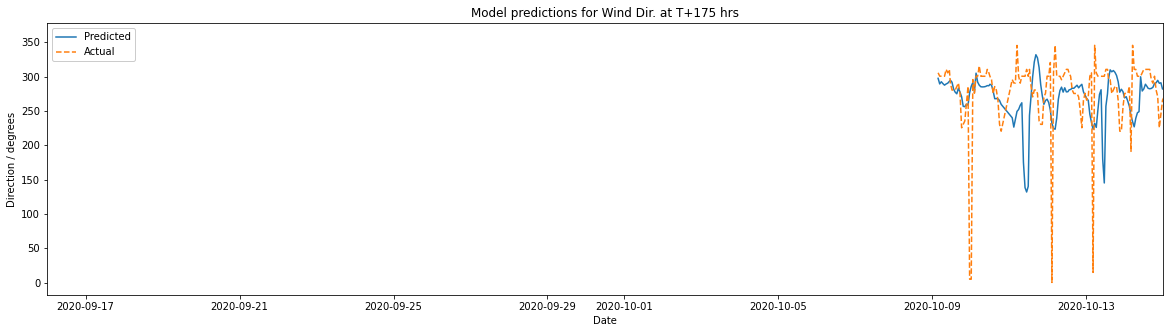

In [ ]:
#Build a wind direction -> wind direction model, predict 1 Sol in advance
MARS_model_DD = MARS_getModel1D()
MARS_buildGenericModel(MARS_model_DD,MARS_normData,2,2,MARS_means, MARS_stds, 12,175)

#5. Conclusion
---
While likely far from an ideal approach to modelling the weather, especially given the simplicity of the models, this notebook renains a clear proof of concept for using extremely short inputs to make reliable predictions. Requiring only two or three measurements grants the network a good amount of flexibility for use cases where data is intermittent. Being able to predict wind parameters with some reliability is a welcome surprise, and with a more sophisticated approach to data prepration and model structure, it is certainly a viable avenue for exploration.
Realistically, two key adjustments need to be made for the weather predictions. For windspeed, the data needs to be averaged over the minutes either side of the chosen point, to reduce the influence of accidentally sampling gusts, which appears to cause a number of spikes in the data. In addition, the wind direction should be converted to a continuous variable (such as by taking the cosine of the bearing) to prevent unphysical jumps.
Comparisons with prior work, along with more detailed analysis, is (as ever) left to the report.

---

---